In [3]:
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_body_barycentric, get_body_barycentric_posvel
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, get_body
from astropy.time import Time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_body_barycentric, get_body_barycentric_posvel
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, get_body, SkyCoord

In [4]:
# ISS spacecraft observation
Eccentricity = 0.0005771
Inclination = 51.6409 # deg
Perigee_Height = 415 # km
Apogee_Height = 423 # km
raan = 88.8414 # deg
Argument_of_Perigee = 75.2083 # deg
True_Anomaly = 0 # deg
R_Earth = 6378.1363 # km
a = (Apogee_Height+Perigee_Height)/2 + R_Earth  # Semi-major axis in km

# Create an Orbit object from the orbital elements
ISS = Orbit.from_classical(Earth, a * u.km, Eccentricity * u.one, Inclination * u.deg,
                            raan * u.deg, Argument_of_Perigee * u.deg, True_Anomaly * u.deg)

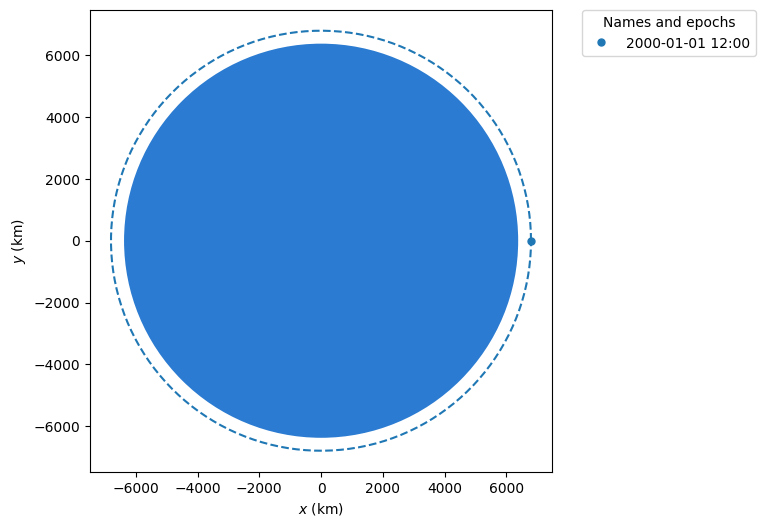

In [5]:
ISS.plot()
# save figure
# plt.savefig('../../Figure/Q4/orbiral.png')

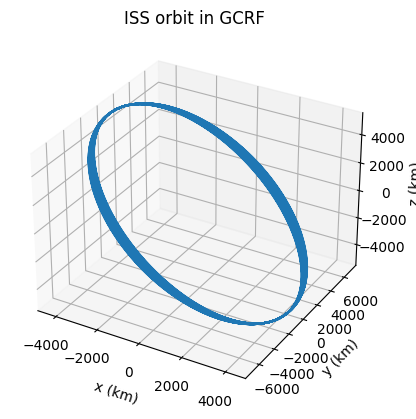

In [7]:
# Simulation of ISS in GCRF for 48 hours


# Constants
mu = 398600.4418 # km^3/s^2
J2 = 1.082626925638815e-3
Re = 6378.1363 # km
omega = 7.2921158553e-5 # rad/s

# Initial conditions
r0 = np.array([ISS.r.value[0], ISS.r.value[1], ISS.r.value[2]])
v0 = np.array([ISS.v.value[0], ISS.v.value[1], ISS.v.value[2]])

# Time span
t = np.linspace(0, 48*3600, 48*3600+1)

# Function to compute the acceleration
def acceleration(r, t):
    r_mag = np.linalg.norm(r)
    r_hat = r/r_mag
    a = -mu/r_mag**2*r_hat
    a[2] = a[2] - 3/2*J2*mu*Re**2/r_mag**4*(5*r[2]**2/r_mag**2-1)*r_hat[2]
    return a

# Function to compute the derivative of the state vector
def state_dot(state, t):
    r = state[:3]
    v = state[3:]
    r_dot = v
    v_dot = acceleration(r, t)
    return np.concatenate((r_dot, v_dot))

# Solving the differential equation
state = odeint(state_dot, np.concatenate((r0, v0)), t)

# Plotting the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(state[:,0], state[:,1], state[:,2])
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('z (km)')
ax.set_title('ISS orbit in GCRF')
plt.show()
# plt.savefig('../../Figure/Q4/GCRF.png')



In [8]:
# Function to crotate GCRF to ITRF with astropy library
def GCRF_to_ITRF(state, t, utc_time):
    # Convert time to astropy time
    t_astropy = Time(utc_time, scale='utc')
    t_astropy = Time(utc_time) + t*u.second
    # Compute the position and velocity of the Earth in GCRF
    earth_pos, earth_vel = get_body_barycentric_posvel('earth', t_astropy)
    # Compute the position and velocity of the ISS in GCRF
    iss_pos = state[:3]
    iss_vel = state[3:]
    # Compute the position and velocity of the ISS in ITRF
    iss_pos_ITRF = iss_pos - earth_pos.xyz.value
    iss_vel_ITRF = iss_vel - earth_vel.xyz.value
    return np.concatenate((iss_pos_ITRF, iss_vel_ITRF))

Text(0.5, 0.92, 'ISS orbit in ITRF')

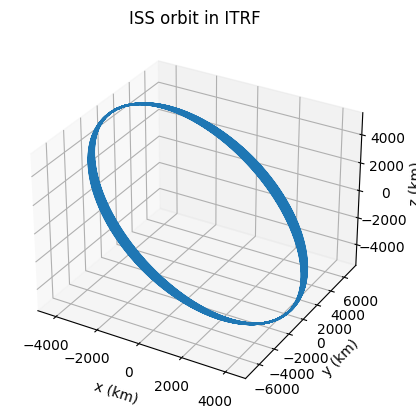

In [9]:
# Convert the state vector from GCRF to ITRF
utc_time = '2000-01-01T12:00:00'
state_ITRF = np.array([GCRF_to_ITRF(state[i,:], t[i], utc_time) for i in range(len(t))])

# Plotting the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(state_ITRF[:,0], state_ITRF[:,1], state_ITRF[:,2])
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('z (km)')
ax.set_title('ISS orbit in ITRF')
# plt.savefig('../../Figure/Q4/ITRF.png')


In [12]:
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy import units as u
lat, lon, elev = 34.224694, 118.057306, 0.03  # Latitude, longitude, and elevation of Los Angeles
los_angeles = EarthLocation(lat=lat, lon=lon, height=elev)
utc_time = '2000-01-01T12:00:00'
t = Time(utc_time, format='isot', scale='utc')
def check_visibility(pos, los_angeles, t):
    # Convert the position of the ISS to astropy coordinates
    iss_pos = SkyCoord(pos[0], pos[1], pos[2], unit='km', frame='gcrs', obstime=t, representation_type='cartesian')
    # # Convert the position of the ISS to AltAz coordinates
    iss_pos_altaz = iss_pos.transform_to(AltAz(obstime=t, location=los_angeles))
    # # Check if the ISS is above the horizon
    # iss_above_horizon = iss_pos_altaz.alt > 0*u.deg
    # # Check if the ISS is above the elevation limit
    iss_above_elevation_limit = iss_pos_altaz.az > 40*u.deg

    # # Check if the ISS is above the elevation limit and above the horizon
    # iss_above_elevation_limit_and_above_horizon = iss_above_elevation_limit & iss_above_horizon
    if iss_above_elevation_limit:
        return 1
    else:
        return 0
    
result = 0
# print(check_visibility(ISS, los_angeles, t))
for i in range(2*24*3600):
    t = Time(utc_time, format='isot', scale='utc') + timedelta(seconds=i)
    visable = check_visibility(state[i, 0:3], los_angeles, t)
    result = result + visable

print(f"visible time: {result} second")



visible time: 169351 second


In [13]:
%pip install git+https://github.com/aperiosoftware/astropy-timeseries.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aperiosoftware/astropy-timeseries.git to /tmp/pip-req-build-hzkhychk
  Running command git clone --filter=blob:none --quiet https://github.com/aperiosoftware/astropy-timeseries.git /tmp/pip-req-build-hzkhychk
  Resolved https://github.com/aperiosoftware/astropy-timeseries.git to commit e27fa334e5ed0669dc284108f38c87c75fe6c29a
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for astropy-timeseries: filename=astropy_timeseries-3.2.dev23463-py3-none-any.whl size=26450 sha256=46cf1414a60359548feedf6a919def684e6fe94b17cafbf398aa5e837db26db0
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0xvpuj2/wheels/87/16/f7/4fd6abe282531912e698810cfc8f33933e60d87284ac5d94af
Successfully built astropy-timeseries


In [23]:
from astropy_timeseries import TimeSeries
latitudes = np.arange(-90, 90, 30)
longitudes = np.arange(-180, 180, 30)

# Initialize a dictionary to store the total view time for each location
view_times = {}
result = 0
# Loop over the latitude and longitude ranges, calculating the total view time for each location
for lat in latitudes:
    for lon in longitudes:
        print(f"Checking location with latitude {lat:.2f} degrees and longitude {lon:.2f} degrees")
        # Define the EarthLocation object for the current location
        ground_loc = EarthLocation(lon=lon, lat=lat, height=0)
        # Store the total view time for the current location in the dictionary
        check = 0
        result = 0
        for i in range(2*24*3600):
          if i % 60 != 0:
            continue
          t = Time(utc_time, format='isot', scale='utc') + timedelta(seconds=i)
          check = check_visibility(state[i, :], ground_loc, t)
          result = check + result
        view_times[(lat, lon)] = result
# Find the location with the highest total view time
best_location = max(view_times, key=view_times.get)

print(f"The best location for the ground station is at latitude {best_location[0]:.2f} degrees and longitude {best_location[1]:.2f} degrees, with a total view time of {view_times[best_location]/3600:.2f} hours over the 48 hour period.")


Checking location with latitude -90.00 degrees and longitude -180.00 degrees
Checking location with latitude -90.00 degrees and longitude -150.00 degrees
Checking location with latitude -90.00 degrees and longitude -120.00 degrees
Checking location with latitude -90.00 degrees and longitude -90.00 degrees
Checking location with latitude -90.00 degrees and longitude -60.00 degrees
Checking location with latitude -90.00 degrees and longitude -30.00 degrees
Checking location with latitude -90.00 degrees and longitude 0.00 degrees
Checking location with latitude -90.00 degrees and longitude 30.00 degrees
Checking location with latitude -90.00 degrees and longitude 60.00 degrees
Checking location with latitude -90.00 degrees and longitude 90.00 degrees
Checking location with latitude -90.00 degrees and longitude 120.00 degrees
Checking location with latitude -90.00 degrees and longitude 150.00 degrees
Checking location with latitude -60.00 degrees and longitude -180.00 degrees
Checking loca

In [24]:
print(f"The best location for the ground station is at latitude {best_location[0]:.2f} degrees and longitude {best_location[1]:.2f} degrees, with a total view time of {view_times[best_location]/60:.2f} hours over the 48 hour period.")

The best location for the ground station is at latitude -30.00 degrees and longitude -60.00 degrees, with a total view time of 47.15 hours over the 48 hour period.
